In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools
import xarray as xr
import datetime
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [21]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
ferry_data = 'https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV1'
nowcast_data = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV17-02'
bathy, X, Y = tidetools.get_bathy_data(grid)
ferry = nc.Dataset(ferry_data)
nowcast = xr.open_dataset(nowcast_data)

In [4]:
nc.num2date(ferry.variables['s.time'][680000], ferry.variables['s.time'].units)

datetime.datetime(2014, 9, 13, 5, 20)

In [5]:
nc.num2date(ferry.variables['s.time'][-1], ferry.variables['s.time'].units)

datetime.datetime(2017, 10, 27, 15, 12)

In [3]:
import pickle

In [7]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [8]:
import os

In [8]:
list_of_model_chl = np.array([])
list_of_ferry_chl = np.array([])
unit = ferry.variables['s.time'].units
for n in range(680000, 1450392):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.chlorophyll'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        date = nc.num2date(ferry.variables['s.time'][n], unit)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date - before).seconds / 3600
            chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                           + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                           + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                       (1- delta)*(nuts2.variables['diatoms'][after.hour, 1, Yind, Xind] 
                           + nuts2.variables['ciliates'][after.hour,1,Yind, Xind] 
                           + nuts2.variables['flagellates'][after.hour,1,Yind,Xind]))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date - before).seconds / 3600
            chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                           + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                           + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                       (1- delta)*(nuts.variables['diatoms'][after.hour, 1, Yind, Xind] 
                           + nuts.variables['ciliates'][after.hour,1,Yind, Xind] 
                           + nuts.variables['flagellates'][after.hour,1,Yind,Xind]))
        list_of_ferry_chl = np.append(list_of_ferry_chl, ferry.variables['s.chlorophyll'][n])
        list_of_model_chl = np.append(list_of_model_chl, chl_val)

In [11]:
output = open('ferry_chl.pkl', 'wb')
pickle.dump(list_of_ferry_chl, output)
output.close()
output = open('model_chl.pkl', 'wb')
pickle.dump(list_of_model_chl, output)
output.close()

In [4]:
list_of_model_chl = pickle.load(open('model_chl.pkl', 'rb'))
list_of_ferry_chl = pickle.load(open('ferry_chl.pkl', 'rb'))

In [11]:
list_of_ferry_chl.shape

(422789,)

In [12]:
print('bias =  ' + str(-np.mean(list_of_ferry_chl) + np.mean(list_of_model_chl)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl - list_of_ferry_chl)**2) / len(list_of_model_chl))))
xbar = np.mean(list_of_ferry_chl)
print('Willmott = ' + str(1-(np.sum((list_of_model_chl - list_of_ferry_chl)**2)  / 
                             np.sum((np.abs(list_of_model_chl - xbar) + np.abs(list_of_ferry_chl - xbar))**2))))

bias =  2.18282683221
RMSE = 4.86143879112
Willmott = 0.498952254572


In [6]:
from matplotlib.colors import LogNorm

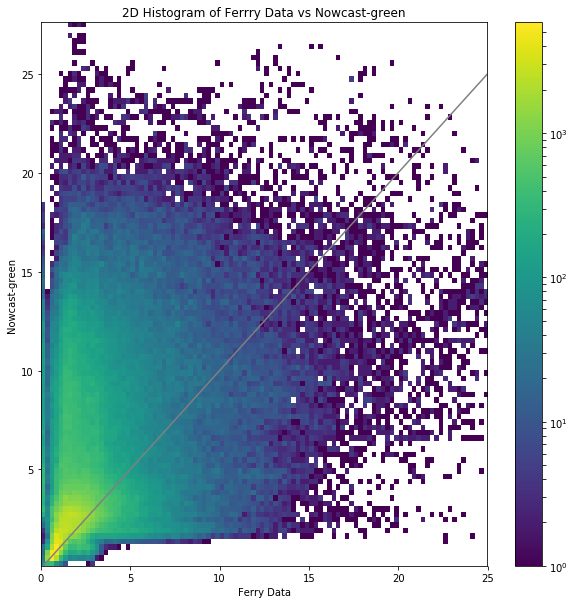

In [20]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferry_chl[list_of_ferry_chl < 25], 
                                list_of_model_chl[list_of_ferry_chl < 25], bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Nowcast-green')
ax.set_title('2D Histogram of Ferrry Data vs Nowcast-green')
ax.plot(np.arange(0,30), 'grey')

In [21]:
print('bias =  ' + str(-np.mean(list_of_ferry_chl[list_of_ferry_chl < 25]) 
                       + np.mean(list_of_model_chl[list_of_ferry_chl < 25])))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl[list_of_ferry_chl < 25] 
                                      - list_of_ferry_chl[list_of_ferry_chl < 25])**2) 
                              / len(list_of_model_chl[list_of_ferry_chl < 25]))))
xbar = np.mean(list_of_ferry_chl[list_of_ferry_chl < 25])
print('Willmott = ' + str(1-(np.sum((list_of_model_chl[list_of_ferry_chl < 25] 
                                     - list_of_ferry_chl[list_of_ferry_chl < 25])**2)  / 
                             np.sum((np.abs(list_of_model_chl[list_of_ferry_chl < 25] - xbar) 
                                     + np.abs(list_of_ferry_chl[list_of_ferry_chl < 25] - xbar))**2))))

bias =  2.2352990434
RMSE = 4.49127647572
Willmott = 0.516927517425
